# Separation time/dist statistic and structure functions 

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.ticker import FormatStrFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes
import m2lib22.diagnosis as diag
import m2lib22.erastar as eras
import m2lib22.stress_to_windterm as stw

from m2lib22.cstes import labels, zarr_dir

In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    w = cluster.scale(jobs=3)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.38:8787/status,
Dashboard: http://10.148.0.38:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.38:58481,Workers: 0
Dashboard: http://10.148.0.38:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## IMPORT DATA, build dataset
We choose to get only erastar wind term, and we reject PEACHY data, and we select only deltaT<1H

In [3]:
DS={}
for l in labels[:5]: 
    #IMPORT DATA
    ds_data = xr.open_zarr(zarr_dir+'/'+l+'.zarr')
    DS[l]=ds_data.isel(site_obs = ds_data.__site_matchup_indice.compute(), alti_time=10, alti_time_mid=10).persist()
    print(l)

gps_SASSA_SARAL_2018
gps_SASSA_Sentinel_2018
argos_SASSA_SARAL_2018
argos_SASSA_Sentinel_2018
argos_SASSA_Sentinel_2016


In [4]:
ds_m_all = xr.concat(list(DS.values()), dim='obs')
ds_m_gps = xr.concat([DS[key] for key in DS if 'gps' in key], dim='obs')
ds_m_argos = xr.concat([DS[key] for key in DS if 'argos' in key], dim='obs')

In [5]:
ds_m_all

<xarray.Dataset>
Dimensions:                        (obs: 175660, box_y: 40, box_x: 80)
Coordinates: (12/19)
    alti_lat                       (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    alti_lon                       (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    alti_time                      int64 10
    alti_time_                     (obs) datetime64[ns] dask.array<chunksize=(9280,), meta=np.ndarray>
    alti_time_mid                  float64 10.5
    alti_x                         (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    ...                             ...
    drifter_time                   (obs) datetime64[ns] dask.array<chunksize=(74235,), meta=np.ndarray>
    drifter_x                      (obs) float64 dask.array<chunksize=(74235,), meta=np.ndarray>
    drifter_y                      (obs) float64 dask.array<chunksize=(74235,), meta=np.ndarray>
    lat                            (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    lon                            (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    time                           (obs) datetime64[ns] dask.array<chunksize=(37118,), meta=np.ndarray>
Dimensions without coordinates: obs
Data variables: (12/61)
    __site_id                      (obs) object dask.array<chunksize=(37118,), meta=np.ndarray>
    __site_matchup_indice          (obs) int32 dask.array<chunksize=(500,), meta=np.ndarray>
    __site_name                    (obs) object dask.array<chunksize=(37118,), meta=np.ndarray>
    alti___distance                (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    alti___source                  (obs) object dask.array<chunksize=(37118,), meta=np.ndarray>
    alti___source_center_index     (obs) object dask.array<chunksize=(37118,), meta=np.ndarray>
    ...                             ...
    drifter_typedeath              (obs) float64 dask.array<chunksize=(74235,), meta=np.ndarray>
    drifter_ve                     (obs) float32 dask.array<chunksize=(74235,), meta=np.ndarray>
    drifter_vn                     (obs) float32 dask.array<chunksize=(74235,), meta=np.ndarray>
    drifter_vx                     (obs) float64 dask.array<chunksize=(74235,), meta=np.ndarray>
    drifter_vy                     (obs) float64 dask.array<chunksize=(74235,), meta=np.ndarray>
    f                              (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
Attributes:
    __id:                   SASSA-L3-SLA-SARAL__gps
    __time_coverage_end:    2019-01-01T00:00:00
    __time_coverage_start:  2018-01-01T00:00:00

# x, y position distribution

In [6]:
_drop = ['drifter_lat','drifter_lon','drifter_time','drifter_x','drifter_y','lat','lon','alti_lat','alti_lon','alti_time','alti_time_','alti_x','alti_y']
ds_diffx_all= (ds_m_all.drifter_x-ds_m_all.alti_x).drop(_drop)
ds_diffy_all= (ds_m_all.drifter_y-ds_m_all.alti_y).drop(_drop)
ds_diffx_gps= (ds_m_gps.drifter_x-ds_m_gps.alti_x).drop(_drop)
ds_diffy_gps= (ds_m_gps.drifter_y-ds_m_gps.alti_y).drop(_drop)
ds_diffx_argos= (ds_m_argos.drifter_x-ds_m_argos.alti_x).drop(_drop)
ds_diffy_argos= (ds_m_argos.drifter_y-ds_m_argos.alti_y).drop(_drop)

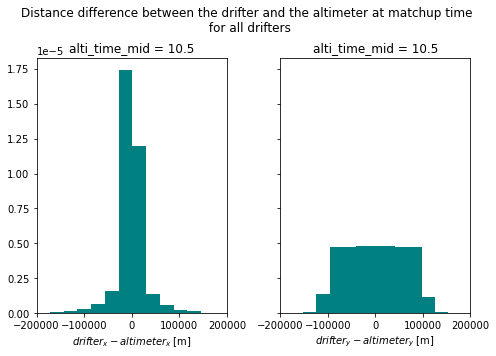

In [7]:
fig, axs = plt.subplots(nrows=1,ncols=2,sharey='all',figsize=(7,5))
ds_diffx_all.plot.hist(bins=30, density=True, color='teal', ax=axs[0])
ds_diffy_all.plot.hist(bins=30, density=True, color='teal', ax=axs[1])
axs[0].set_xlabel(r'$drifter_x-altimeter_x$ [m]')
axs[1].set_xlabel(r'$drifter_y-altimeter_y$ [m]')
axs[0].set_xlim(-2e5,2e5)
axs[1].set_xlim(-2e5,2e5)
fig.suptitle("Distance difference between the drifter and the altimeter at matchup time \n for all drifters")
fig.tight_layout(rect=[0,0,1,1.02])

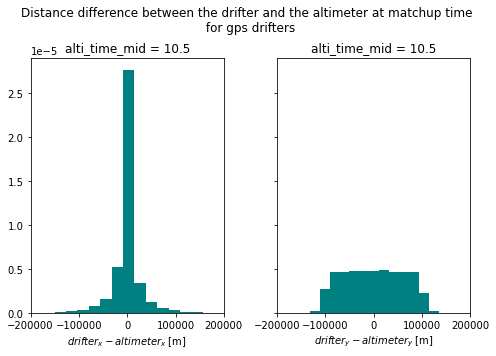

In [8]:
fig, axs = plt.subplots(nrows=1,ncols=2,sharey='all',figsize=(7,5))
ds_diffx_gps.plot.hist(bins=30, density=True, color='teal', ax=axs[0])
ds_diffy_gps.plot.hist(bins=30, density=True, color='teal', ax=axs[1])
axs[0].set_xlabel(r'$drifter_x-altimeter_x$ [m]')
axs[1].set_xlabel(r'$drifter_y-altimeter_y$ [m]')
axs[0].set_xlim(-2e5,2e5)
axs[1].set_xlim(-2e5,2e5)
fig.suptitle("Distance difference between the drifter and the altimeter at matchup time \n for gps drifters")
fig.tight_layout(rect=[0,0,1,1.02])

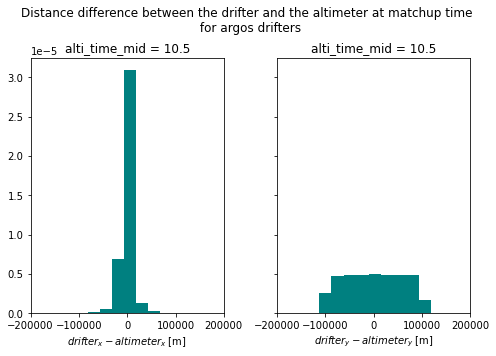

In [9]:
fig, axs = plt.subplots(nrows=1,ncols=2,sharey='all',figsize=(7,5))
ds_diffx_argos.plot.hist(bins=30, density=True, color='teal', ax=axs[0])
ds_diffy_argos.plot.hist(bins=30, density=True, color='teal', ax=axs[1])
axs[0].set_xlabel(r'$drifter_x-altimeter_x$ [m]')
axs[1].set_xlabel(r'$drifter_y-altimeter_y$ [m]')
axs[0].set_xlim(-2e5,2e5)
axs[1].set_xlim(-2e5,2e5)
fig.suptitle("Distance difference between the drifter and the altimeter at matchup time \n for argos drifters")
fig.tight_layout(rect=[0,0,1,1.02])

# Structure function
$$\overrightarrow{dy} = \lvert\overrightarrow{x_d}-\vec{x_s}\rvert$$
$$S_{//}(r)=\langle(g\partial_x\eta( \overrightarrow{x_s})-(-fv(\overrightarrow{x_d})))^2\rangle$$

In [30]:
_drop = ['alti_lat','alti_lon','alti_time','alti_time_','alti_time_mid','alti_x','alti_x_mid','alti_y','alti_y_mid','drifter_lat','drifter_lon','drifter_time','drifter_x','drifter_y','lat','lon','time']
ds_all=xr.Dataset()
ds_all['dy']=abs(ds_m_all.drifter_y-ds_m_all.drifter_y)
ds_all['S_parallele']=((ds_m_all.drifter_coriolis_x-ds_m_all.alti_denoised_g_grad_x)**2)#.drop([v for v in list(ds_m_all.coords) if v!='time'])
ds_all = ds_all.drop(_drop).set_coords('dy').sortby('dy')
ds_all

<xarray.Dataset>
Dimensions:      (obs: 175660)
Coordinates:
    dy           (obs) float64 dask.array<chunksize=(74235,), meta=np.ndarray>
Dimensions without coordinates: obs
Data variables:
    S_parallele  (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>

In [31]:
ds_all.dy.compute()

<xarray.DataArray 'dy' (obs: 175660)>
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
    dy       (obs) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
Dimensions without coordinates: obs

In [32]:
dy_bin = np.arange(0,9e5, 1e4)
#print(len(dy_bin))
#dy_intervals = [0]+[(dy_bin[i+1]+dy_bin[i])/2  for i in range(len(dy_bin)-1)]+[dy_bin[-1]]

In [ ]:
l=[]
for i in range(len(dy_bin)):
    mean_S_parallele = ds_all.where(ds_all.dy>dy_intervals[i], drop=True).where(ds_all.dy<=dy_intervals[i+1], drop=True).mean()
    l.append(mean_S_parallele)
l


KeyboardInterrupt



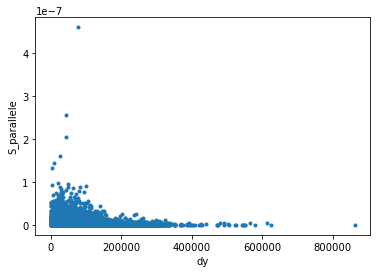

In [38]:
ds_all.S_parallele.plot(x='dy', ls='', marker ='.')

https://docs.xarray.dev/en/stable/user-guide/groupby.html

In [13]:
ds_bin_all = ds_all.groupby_bins('dy',dy_bin,include_lowest=True)

In [18]:
ds_bin_all_mean= ds_bin_all.mean('obs')

In [28]:
ds_bin_all_mean

<xarray.Dataset>
Dimensions:      (dy_bins: 89)
Coordinates:
  * dy_bins      (dy_bins) object (-0.001, 10000.0] ... (880000.0, 890000.0]
Data variables:
    S_parallele  (dy_bins) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [1]:
cluster.close()

NameError: name 'cluster' is not defined